In [1]:
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import seaborn as sns
import csv

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Models
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Training
from sklearn.model_selection import train_test_split, StratifiedKFold

# Evaluation
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [2]:
class Col:
    id = 'PassengerId'
    pclass = 'Pclass'
    name = 'Name'
    sex = 'Sex'
    age = 'Age'
    sibsp = 'SibSp'
    parch = 'Parch'
    ticket = 'Ticket'
    fare = 'Fare'
    cabin = 'Cabin'
    embarked = 'Embarked'

In [3]:
# Data files live in the GitHub repo for this project
dataset = pd.read_csv('https://raw.githubusercontent.com/EricXDong/kaggle-projects/master/competitions/titanic/train.csv')
X_test = pd.read_csv('https://raw.githubusercontent.com/EricXDong/kaggle-projects/master/competitions/titanic/test.csv')

X_train = dataset.drop(columns = ['Survived'])
y_train = dataset['Survived']

print(f'{len(y_train)} total passengers')
print(f'{y_train.sum()} survived')
print(f'{len(y_train) - y_train.sum()} did not survive')
X_train.head()

891 total passengers
342 survived
549 did not survive


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Passenger demographics

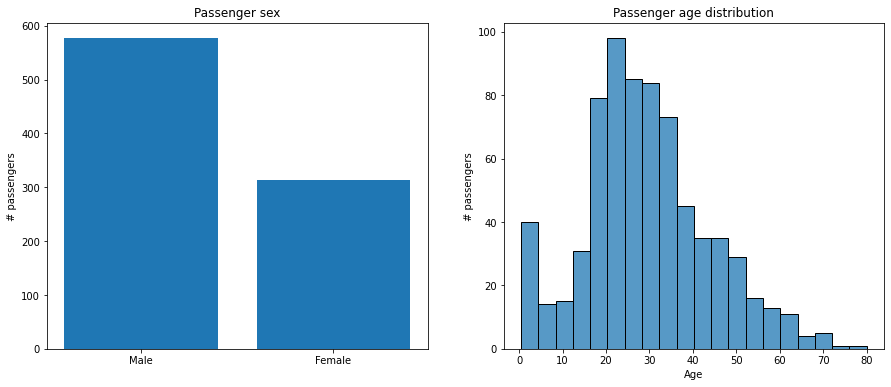

In [4]:
# Count the number of males and females
num_males = (X_train[Col.sex] == 'male').sum()
num_females = (X_train[Col.sex] == 'female').sum()

# Plot sex and age distribution

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))

ax1.set_title('Passenger sex')
ax1.bar(['Male', 'Female'], [num_males, num_females])
ax1.set_ylabel('# passengers')

sns.histplot(data = X_train[Col.age], ax = ax2)
ax2.set(ylabel = '# passengers', title = 'Passenger age distribution')

pass

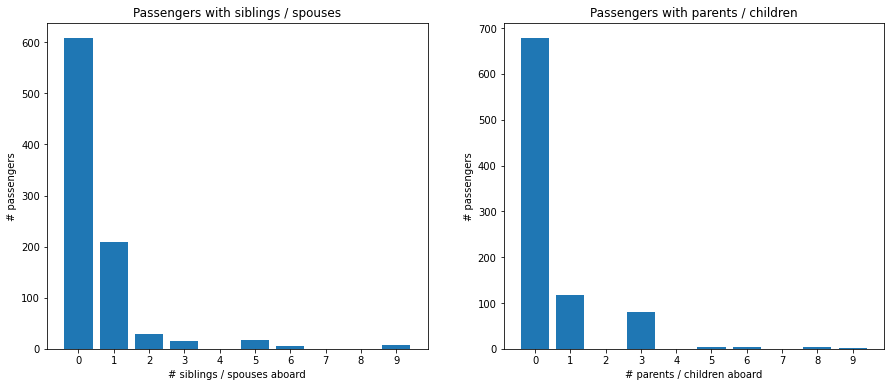

In [5]:
# Examine distribution of relatives

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))

# Plot siblings and spouses

sibsp = np.histogram(X_train[Col.sibsp])[0]
x = range(len(sibsp))

ax1.bar(x, sibsp)
ax1.set(
    title = 'Passengers with siblings / spouses',
    xlabel = '# siblings / spouses aboard',
    ylabel = '# passengers',
    xticks = x
)

# Plot parents and children

parch = np.histogram(X_train[Col.parch])[0]
x = range(len(parch))

ax2.bar(range(len(parch)), parch)
ax2.set(
    title = 'Passengers with parents / children',
    xlabel = '# parents / children aboard',
    ylabel = '# passengers',
    xticks = x
)

pass

In [6]:
# Count the number of passengers per class
class_count = np.histogram(X_train[Col.pclass], bins = 3)
class_count = class_count[0]

# Get the distribution of fares
fares = np.histogram(X_train[Col.fare], bins = range(0, 600, 50))

# Plot

fig = make_subplots(
    rows = 1,
    cols = 2,
    column_widths = [0.3, 0.7],
    subplot_titles = ['Passengers per class', 'Passenger fares']
)

fig.add_trace(
    go.Bar(
        x = ['First class', 'Second class', 'Third class'],
        y = class_count,
        width = 0.5
    ),
    row = 1,
    col = 1
)

fig.add_trace(
    go.Histogram(x = X_train[Col.fare]),
    row = 1,
    col = 2
)

fig.update_layout(
    showlegend = False
)

## Clean data

In [7]:
# Determine columns with missing data

null_cols = X_train.isnull().any()
print(f'Training set columns with missing data: {null_cols[null_cols].index.tolist()}')

null_cols = X_test.isnull().any()
print(f'Test set columns with missing data: {null_cols[null_cols].index.tolist()}')

# Examine missing age data
num_missing = X_train[Col.age].isnull().sum()
print(f'\n{num_missing} entries out of {len(y_train)} are missing age data.')

# Examine missing fare data
num_missing = X_test[Col.fare].isnull().sum()
print(f'\n{num_missing} entries out of {len(y_train)} (in the test set) are missing fare data.')

# Examine missing cabin data
num_missing = X_train[Col.cabin].isnull().sum()
num_unique = len(X_train[Col.cabin].unique())
print(f'\n{num_missing} entries out of {len(y_train)} are missing cabin data.')
print(f'From the data we do have, there are {num_unique - 1} unique values')

# Examine missing embarkation data

num_missing = X_train[Col.embarked].isnull().sum()
num_unique = len(X_train[Col.embarked].unique())
print(f'\n{num_missing} entries out of {len(y_train)} are missing embarkation data.')
print(f'From the data we do have, there are {num_unique - 1} unique values')


Training set columns with missing data: ['Age', 'Cabin', 'Embarked']
Test set columns with missing data: ['Age', 'Fare', 'Cabin']

177 entries out of 891 are missing age data.

1 entries out of 891 (in the test set) are missing fare data.

687 entries out of 891 are missing cabin data.
From the data we do have, there are 147 unique values

2 entries out of 891 are missing embarkation data.
From the data we do have, there are 3 unique values


## Columns with missing data across both the training and test sets

### Age (numerical)
20% of the training set is missing age data. That's enough entries that we can't just drop them, but probably not enough that we'd be inclined to drop the entire column. Therefore, the missing values should be imputed. Using zero, minimum, and maximum don't make sense for age, so we'll use the median value here.

### Cabin (categorical)
A lot more entries are missing cabin data (about 77%). Not only that, but it would be more complicated to impute cabin data. There's a wide range of possible values, and you can't exactly say that nearly 700 people stayed in the same (most common value) cabin. We'll drop this column for the purposes of this project.

### Embarked (categorical)
This feature seems to only have 3 possible values (i.e. 3 possible ports of embarkation). Only having 2 entries missing this feature means we could just drop them, but we'll impute the most common value instead because this is a pretty small dataset.

### Fare (numerical)
Only one entry is missing this feature. Since fare is more continuous than age, we'll impute the mean instead of median (though there probably wouldn't be much of a difference). This missing entry is in the test set though, so we have to be sure to use the training set's mean in order to avoid data leakage.

## Additional columns to drop
The name and ticket features most likely have negligible impact on survival (especially name). They may even lead the model to become incorrectly biased towards certain names just because they coincidentally appear in the dataset more. For these reasons, we'll drop both columns.

In [8]:
# Drop unneeded features
X_train = X_train.drop(columns = [Col.cabin, Col.name, Col.ticket])
X_test = X_test.drop(columns = [Col.cabin, Col.name, Col.ticket])

# Define imputers
median_inputer = SimpleImputer(strategy = 'median')
freq_imputer = SimpleImputer(strategy = 'most_frequent')
fare_mean = X_train[Col.fare].mean()

# Define one hot encoding for categorical features

is_cat_col = X_train.dtypes == 'object'
cat_cols = is_cat_col[is_cat_col].index.tolist()

onehot_pipeline = make_pipeline(
    freq_imputer,
    OneHotEncoder()
)

# Set up the preprocessing pipeline
preprocessor = ColumnTransformer(transformers = [
    ('median_inputer', median_inputer, [Col.age]),
    ('onehot', onehot_pipeline, cat_cols)
])

###### Quick note
Sex is a feature that could be binary encoded for this dataset (though it's important to note that this isn't always the case, since there could be other possible values such as 'Choose not to answer'). The primary advantage of binary vs. one-hot encoding is on the performance side, since one-hot encoding would add an additional column compared to binary. However, this dataset is relatively tiny, so the performance difference is negligible.


# Choosing the right model
Scikit-learn has a [useful diagram](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) for choosing the right model for your problem. Ours is a classification problem, and we have a number of options here. Since the dataset is so small, we can afford to try out and evaluate multiple types of models without worrying about long wait times.

We'll try out the following models, along with a grid search for each one to find the best hyperparameters:
- [K neighbors classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [Random forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

We'll also leverage the preprocessing pipeline set up above during our grid search so that the data is in good shape.

## Model evaluation

### Scoring
For this competition, we only really care about accuracy. The best performing model in terms of accuracy will be the final model we run and submit on the test set.

### Validation
Sklearn's GridSearchCV already performs cross validation when selecting the best model. However, we'll still want to split off some exta validation data to run through the model outside of grid search. This allows us to estimate how well the model would perform in the "real world".

In [9]:
# Define models
knn = KNeighborsClassifier()
forest = RandomForestClassifier(random_state = 42)
svc = SVC(random_state = 42)

# Map models to their hyperparameters for grid search
model_step_name = 'model'
models = [
    # Prepend params with the pipeline step to apply the params to
    (knn, {
        f'{model_step_name}__n_neighbors': [3, 5, 7, 9, 11],
        f'{model_step_name}__p': [1, 2]
    }),
    (forest, {
        f'{model_step_name}__n_estimators': [5, 10, 20, 40, 80],
        f'{model_step_name}__min_samples_split': [2, 3, 5, 8],
        f'{model_step_name}__min_samples_leaf': [2, 4, 8, 16, 32],
    }),
    (svc, {
        f'{model_step_name}__C': [0.1, 0.5, 5, 25],
        f'{model_step_name}__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        f'{model_step_name}__degree': [1, 2, 3, 4]
    }),
]

In [10]:
# Split out the validation data
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size = 0.2,
    random_state = 42
)

# Run 
for model in models:
    # Manually set the pipeline step name for the model so it matches the param grid
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (model_step_name, model[0])])
    
    clf = GridSearchCV(
        pipeline,
        param_grid = model[1],
        scoring = make_scorer(accuracy_score),
        cv = StratifiedKFold()
    )
    clf.fit(X_train, y_train)
    
    print(f'Model: {model[0].__class__.__name__}\n')
    print(f'Training results')
    print(f'Best accuracy: {round(clf.best_score_, 4)}')
    print(f'Best hyperparameters: {clf.best_params_}\n')
    
    # Now run on the validation set
    best_model = clf.best_estimator_
    preds = best_model.predict(X_valid)
    accuracy = accuracy_score(y_valid, preds)
    print(f'Validation accuracy: {round(accuracy, 4)}\n\n===============================\n')

Model: KNeighborsClassifier

Training results
Best accuracy: 0.7824
Best hyperparameters: {'model__n_neighbors': 5, 'model__p': 1}

Validation accuracy: 0.7765


Model: RandomForestClassifier

Training results
Best accuracy: 0.7963
Best hyperparameters: {'model__min_samples_leaf': 8, 'model__min_samples_split': 2, 'model__n_estimators': 40}

Validation accuracy: 0.7709


Model: SVC

Training results
Best accuracy: 0.7949
Best hyperparameters: {'model__C': 25, 'model__degree': 1, 'model__kernel': 'rbf'}

Validation accuracy: 0.7821




## Test results

It looks like the SVC performed the best, with a 78.21% accuracy score on the validation set. We'll use that for our final model.

## Final run and submission

In [13]:
# Final model
model = SVC(
    random_state = 42,
    C = 25,
    degree = 1,
    kernel = 'rbf'
)

pipeline = make_pipeline(preprocessor, model);
pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)

In [18]:
# Pair with passenger IDs
ids = X_test[Col.id]
ids = ids.to_list()

output = list(zip(ids, preds))

# Output to CSV
with open('submission.csv', mode = 'w') as file:
  writer = csv.writer(file)
  writer.writerow(['PassengerId', 'Survived'])

  for o in output:
    writer.writerow([o[0], o[1]])
  

In [19]:
# Colab-specific, downloads the file to local machine
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>